In [ ]:
# Librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import zipfile

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving blood+transfusion+service+center.zip to blood+transfusion+service+center.zip


In [ ]:
# Extraer solo el archivo de datos
with zipfile.ZipFile('blood+transfusion+service+center.zip', 'r') as zip_ref:
    zip_ref.extract('transfusion.data')

In [ ]:

# Definir nombres de las columnas según el archivo .names
column_names = ['Recency', 'Frequency', 'Monetary', 'Time', 'Donated']

# Cargar los datos con nombres de columnas
df = pd.read_csv('transfusion.data', names=column_names, header=0)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Donated    748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


Verificamos que no existe la presencia de valores nulos y el tipo de datos esta correcto.

R (Recency - months since last donation),

F (Frequency - total number of donation),

M (Monetary - total blood donated in c.c.),

T (Time - months since first donation),

a binary variable representing whether he/she donated blood in March 2007 (1
stand for donating blood; 0 stands for not donating blood).

In [ ]:
df.describe()

,Recency,Frequency,Monetary,Time,Donated
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


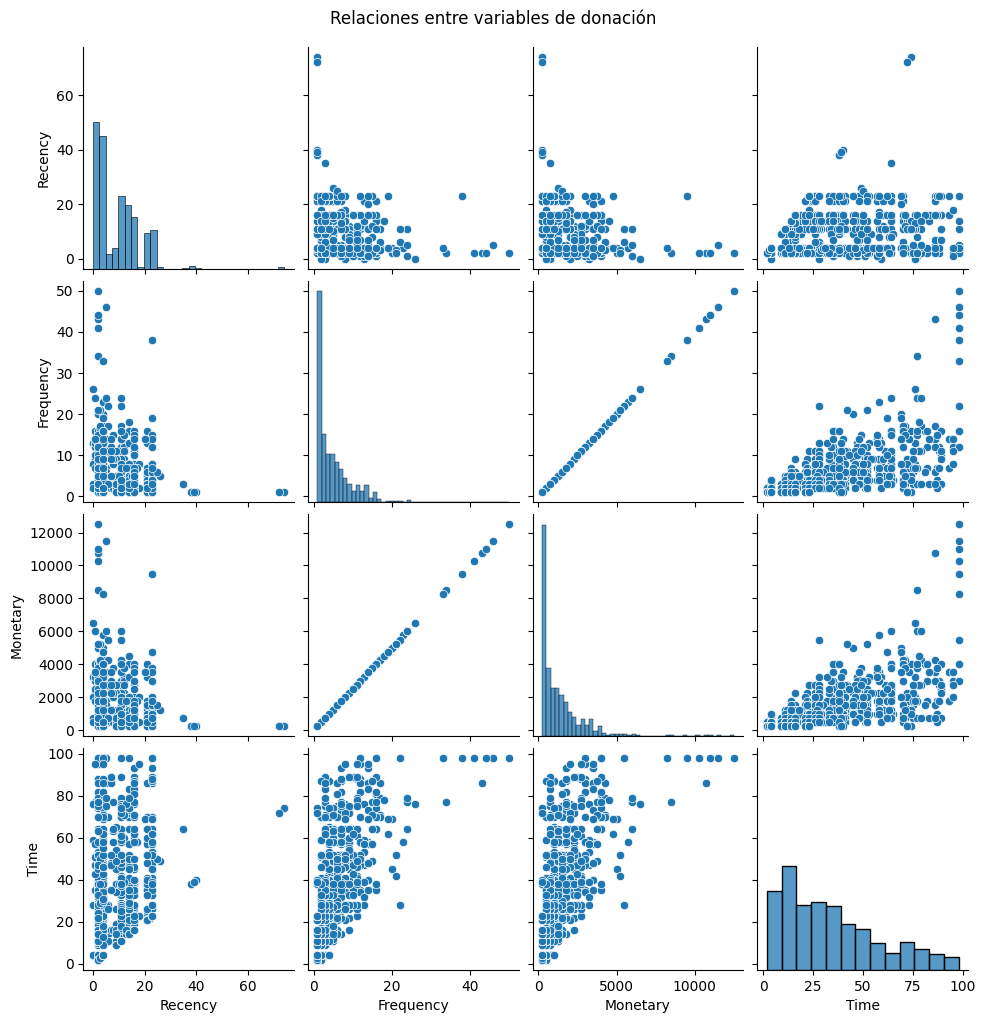

In [ ]:
# --- Exploración visual inicial ---
sns.pairplot(df.drop('Donated', axis=1))
plt.suptitle("Relaciones entre variables de donación", y=1.02)
plt.show()

Las variables Recency, Frequency, Monetary y Time están sesgadas a la derecha. Hay una gran concentración de valores bajos con algunos valores mucho más altos (colas largas).

 Frequency y Monetary: Se observa una línea diagonal perfecta, lo que tiene sentido ya que Monetary representa el número total de unidades de sangre donadas (cantidad fija multiplicada por la frecuencia).

 No hay una tendencia clara entre Recency (días desde la última donación) y las demás variables.

 Time con mayor dispersion , Algunos donantes tienen períodos muy largos como clientes..

In [ ]:

# --- Escalado de las variables ---
features = ['Recency', 'Frequency', 'Monetary', 'Time']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(X_scaled, columns=features)

In [ ]:
# --- Función para detectar outliers por IQR ---
def detect_outliers_iqr(dataframe):
    outliers = pd.DataFrame(False, index=dataframe.index, columns=dataframe.columns)
    for col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)
    return outliers

In [ ]:

# --- Detección de outliers por columna ---
outliers_iqr = detect_outliers_iqr(df_scaled)
df['outlier_iqr'] = outliers_iqr.any(axis=1)

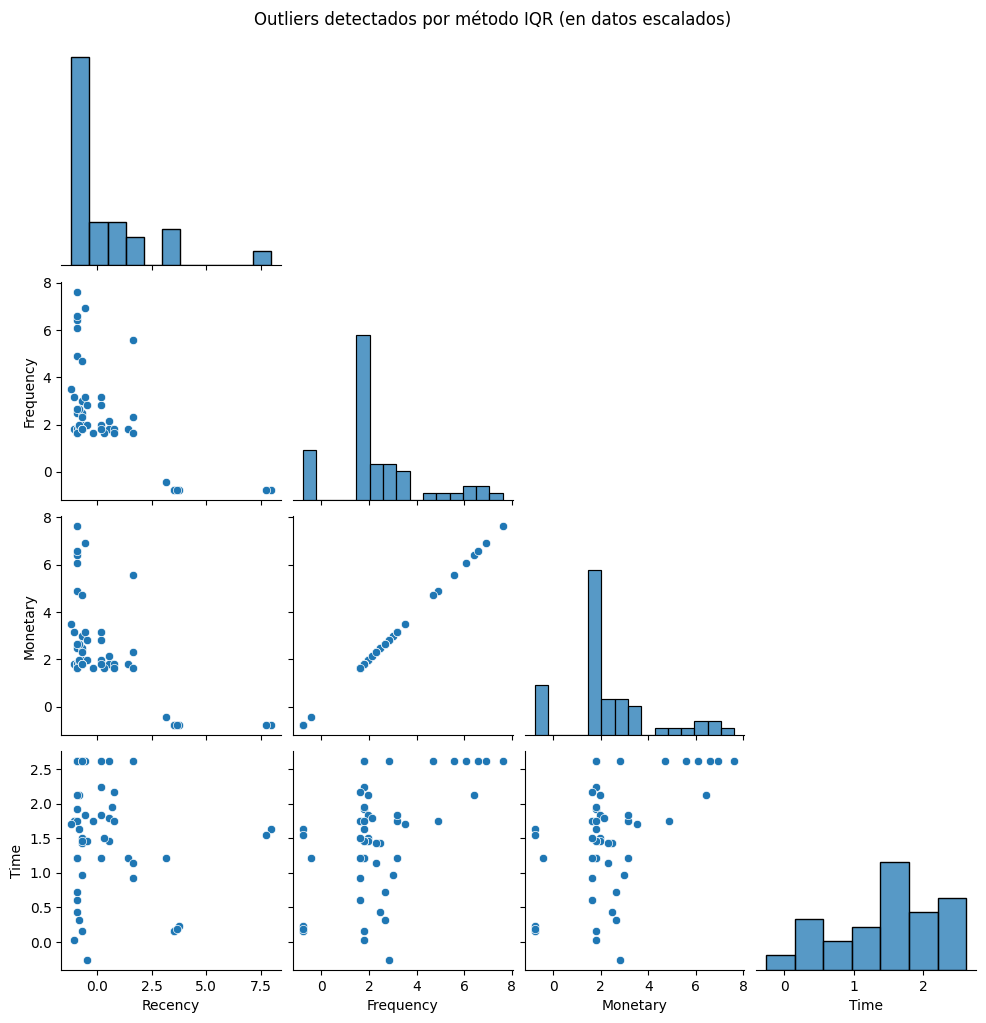

🔍 Total de outliers detectados con IQR (en alguna variable): 52


In [ ]:
# --- Visualización ---
sns.pairplot(df_scaled[outliers_iqr.any(axis=1)], corner=True)
plt.suptitle("Outliers detectados por método IQR (en datos escalados)", y=1.02)
plt.show()

# --- Resultado final ---
total_outliers = df['outlier_iqr'].sum()
print(f"🔍 Total de outliers detectados con IQR (en alguna variable): {total_outliers}")

Estos puntos están lejos del "centro" de los datos, lo que indica donantes muy diferentes del patrón general (por ejemplo, donantes extremadamente frecuentes o recientes).

Densidad concentrada en el centro: La mayoría de los datos están agrupados cerca del origen (0), lo cual es típico luego del escalado.



Conclusiones generales
El dataset contiene valores atípicos reales, especialmente en Frequency, Monetary y Recency. Esto indica la presencia de donantes que difieren fuertemente del patrón común (p. ej., algunos han donado muchas más veces que el promedio o lo han hecho muy recientemente).

El escalado mejora la visibilidad de estos valores extremos. Esto es útil antes de aplicar modelos de clustering, PCA o algoritmos sensibles a la escala.
